In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import gamma, kv
from numpy import matlib

import torch
import mgplvm as mgp
import pickle
import time
from sklearn.decomposition import FactorAnalysis
from sklearn.linear_model import LinearRegression, Ridge
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
plt.rcParams['font.size'] = 20
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
np.random.seed(0)
torch.manual_seed(0)
device = mgp.utils.get_device() # use GPU if available, otherwise CPU
print(device)

import random
random.seed(0)

from scipy.linalg import cholesky
import scipy

from mgplvm.fast_utils import sym_toeplitz_matmul
from mgplvm.fast_utils import broadcasting

loading
cuda


In [3]:
def squared_exponential_kernel(r, l):
    """
    Squared exponential kernel function
    """
    return np.exp(-(r**2)/(2*l**2))

[ 1.24988336e+00  5.79037343e-03  8.43697572e-01 -1.11101965e-04
  2.58852854e-01 -1.96845594e-03  3.74720891e-02 -1.15985073e-03
  2.73363730e-03 -5.68848155e-04  7.19621236e-04 -3.51510636e-04
  1.07807937e-04 -2.28212834e-04  3.37865868e-04 -1.77232095e-04
  3.69797393e-05 -1.25677449e-04  2.08276755e-04 -1.08774563e-04
  1.65799907e-05 -7.95919013e-05  1.41163886e-04 -7.41435952e-05
  8.80132810e-06 -5.48008357e-05  1.01879691e-04 -5.40538069e-05
  5.26890549e-06 -3.99216505e-05  7.69345726e-05 -4.13124236e-05
  3.45120914e-06 -3.02950384e-05  6.01245039e-05 -3.27024098e-05
  2.42369015e-06 -2.37140867e-05  4.82679841e-05 -2.66000992e-05
  1.79876461e-06 -1.90209520e-05  3.95974297e-05 -2.21110128e-05
  1.39583378e-06 -1.55599639e-05  3.30676559e-05 -1.87082958e-05
  1.12338589e-06 -1.29370472e-05  2.80288566e-05 -1.60647449e-05
  9.31777716e-07 -1.09037412e-05  2.40599958e-05 -1.39681999e-05
  7.92510792e-07 -9.29710190e-06  2.08786430e-05 -1.22760788e-05
  6.88425531e-07 -8.00668

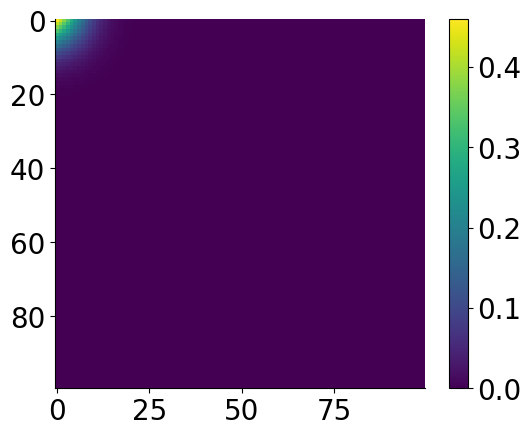

In [4]:
l = 0.2
start = 0
stop = 10
dt = 0.02
x_axis = np.linspace(start, stop-dt, int((stop-start)/dt))
K = squared_exponential_kernel(x_axis[:, None] - x_axis[None, :], l)
# plt.imshow(K)
# plt.show()

K_1_2 = np.linalg.cholesky(K + np.eye(len(x_axis))*1e-6)
# plt.imshow(K_1_2)
# plt.show()

K_1_2_approx = ((2/np.pi)**(1/4))*np.sqrt(dt/l)*squared_exponential_kernel(x_axis[:, None] - x_axis[None, :], l/np.sqrt(2))
def k_1_2(omega, l):
    prefactor =  ((2*np.pi)**(1/4)) * (l**(-1/2))
    return prefactor * np.exp(-((omega*l)**2) / 4)

T = K_1_2_approx.shape[0]
print(np.fft.irfft(k_1_2(np.fft.fftfreq(T, d=dt), l)))

row = np.zeros(2*(T-1))
row[:T] = K_1_2_approx[0, :]
row[T:] = K_1_2_approx[0, -2:0:-1]
print(row)
# plt.show()
# print(np.abs(np.fft.rfft(row)))

# plt.imshow(K_1_2_approx)
# plt.show()

K_1_2_approx2 = (2/np.pi)**(1/4)*(l)**(-3/2)*squared_exponential_kernel(x_axis[:, None] - x_axis[None, :], l/np.sqrt(2))
# plt.imshow(K_1_2_approx2)
# plt.show()

# plt.imshow(np.abs(K - K_1_2.dot(K_1_2.T) - np.eye(len(x_axis))*1e-6))
# plt.colorbar()
# plt.show()

plt.imshow(np.abs(K - K_1_2_approx.dot(K_1_2_approx))[:100, :100])
plt.colorbar()
plt.show()
# print(np.sum(np.abs(K - K_1_2_approx.dot(K_1_2_approx)), axis=0))

# print(np.abs(K - K_1_2_approx2.dot(K_1_2_approx2)))



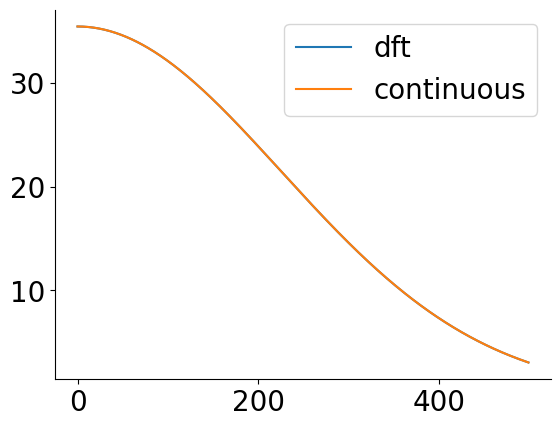

In [5]:
def gaussian_pulse(a, t):
    return np.exp(-(a*t)**2)
def fourier(f, a):
    omega = 2*np.pi*f
    return (np.sqrt(np.pi)/a)*np.exp(-(omega**2)/(4*(a**2)))
def extend(p):
    T = len(p)
    row = np.zeros(2*(T-1))
    row[:T] = p[:]
    row[T:] = p[-2:0:-1]
    return row

a = 100
t = np.linspace(0, 5, 10000)
p = extend(gaussian_pulse(a, t))
dft = np.fft.fft(p)

new_l = 2 * len(t) - 1
f = fourier(np.fft.fftfreq(new_l, d=t[1]-t[0]), a) / (2*(t[-1])) * new_l
plt.plot(np.real(dft)[:500], label='dft')
plt.plot(np.real(f)[:500], label='continuous')
plt.legend()
plt.show()



In [6]:
dt = 1
T = 100
t = np.linspace(0, T-dt, int(T/dt))

f_0 = 1/dt

print(np.fft.rfftfreq(len(t), d=dt))#/(2 * np.pi)
print(np.fft.fftfreq(len(t), d=dt))#/(2 * np.pi)


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
[ 0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23
  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35
  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47
  0.48  0.49 -0.5  -0.49 -0.48 -0.47 -0.46 -0.45 -0.44 -0.43 -0.42 -0.41
 -0.4  -0.39 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31 -0.3  -0.29
 -0.28 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17
 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05
 -0.04 -0.03 -0.02 -0.01]


In [7]:
def sym_toeplitz_matmul2(toeplitz_column, tensor):
    """
    Performs a matrix-matrix multiplication TM where the matrix T is symmetric Toeplitz.
    Args:
        - toeplitz_column (vector n) - First column of the symmetric Toeplitz matrix T.
        - matrix (matrix n x p) - Matrix or vector to multiply the Toeplitz matrix with.
    Returns:
        - tensor
    """
    return toeplitz_matmul2(toeplitz_column, toeplitz_column, tensor)

def toeplitz_matmul2(toeplitz_column, toeplitz_row, tensor):
    """
    Performs multiplication T * M where the matrix T is Toeplitz.
    Args:
        - toeplitz_column (vector n or b x n) - First column of the Toeplitz matrix T.
        - toeplitz_row (vector n or b x n) - First row of the Toeplitz matrix T.
        - tensor (matrix n x p or b x n x p) - Matrix or vector to multiply the Toeplitz matrix with.
    Returns:
        - tensor (n x p or b x n x p) - The result of the matrix multiply T * M.
    """
    if toeplitz_column.size() != toeplitz_row.size():
        raise RuntimeError(
            "c and r should have the same length (Toeplitz matrices are necessarily square)."
        )

    toeplitz_shape = torch.Size((*toeplitz_column.shape, toeplitz_row.size(-1))) # abcc
    output_shape = broadcasting._matmul_broadcast_shape(toeplitz_shape,
                                                        tensor.shape)
    broadcasted_t_shape = output_shape[:-1] if tensor.dim(
    ) > 1 else output_shape
    # print(output_shape) #abc1

    if tensor.ndimension() == 1:
        tensor = tensor.unsqueeze(-1)
    toeplitz_column = toeplitz_column.expand(*broadcasted_t_shape)
    toeplitz_row = toeplitz_row.expand(*broadcasted_t_shape)
    tensor = tensor.expand(*output_shape)

    if not torch.equal(toeplitz_column[..., 0], toeplitz_row[..., 0]):
        raise RuntimeError(
            "The first column and first row of the Toeplitz matrix should have "
            "the same first element, otherwise the value of T[0,0] is ambiguous. "
            "Got: c[0]={} and r[0]={}".format(toeplitz_column[0],
                                              toeplitz_row[0]))

    if type(toeplitz_column) != type(toeplitz_row) or type(
            toeplitz_column) != type(tensor):
        raise RuntimeError("The types of all inputs to ToeplitzMV must match.")

    *batch_shape, orig_size, num_rhs = tensor.size()
    r_reverse = toeplitz_row[..., 1:].flip(dims=(-1,))

    c_r_rev = torch.zeros(*batch_shape,
                          orig_size + r_reverse.size(-1),
                          dtype=tensor.dtype,
                          device=tensor.device)
    c_r_rev[..., :orig_size] = toeplitz_column
    c_r_rev[..., orig_size:] = r_reverse
    # print('c_r_rev shape', c_r_rev.shape)

    temp_tensor = torch.zeros(*batch_shape,
                              2 * orig_size - 1,
                              num_rhs,
                              dtype=toeplitz_column.dtype,
                              device=toeplitz_column.device)
    temp_tensor[..., :orig_size, :] = tensor
    # print(toeplitz_column.dtype) # torch.float64
    # print('temp tensor shape', temp_tensor.shape)

    fft_M = torch.fft.fft(temp_tensor.transpose(-1, -2).contiguous())
    fft_c = torch.fft.fft(c_r_rev)
    plt.plot(fft_c.numpy())
    # print('fft_c shape', fft_c.shape)
    fft_c = fft_c.unsqueeze(-2)
    # print('fft_c shape unsqueeze', fft_c.shape)
    # print(fft_c)
    fft_c = fft_c.expand_as(fft_M)
    # print('fft_c shape final', fft_c.shape)
    # print(fft_c)
    fft_product = fft_M.mul_(fft_c)

    output = torch.fft.ifft(fft_product).real.transpose(-1, -2)
    output = output[..., :orig_size, :]
    return output

In [8]:
def fourier_toeplitz_matmul(fourier_func, func_args, tensor, matrix_shape: tuple, dt, T):
    """
    Performs multiplication T * M where the matrix T is Toeplitz.
    Args:
        - toeplitz_column (vector n or b x n) - First column of the Toeplitz matrix T.
        - toeplitz_row (vector n or b x n) - First row of the Toeplitz matrix T.
        - tensor (matrix n x p or b x n x p) - Matrix or vector to multiply the Toeplitz matrix with.
    Returns:
        - tensor (n x p or b x n x p) - The result of the matrix multiply T * M.
    """

    # Replacing toeplitz_column.shape with input matrix_shape
    toeplitz_shape = torch.Size((*matrix_shape, matrix_shape[-1]))
    output_shape = broadcasting._matmul_broadcast_shape(toeplitz_shape,
                                                        tensor.shape)
    broadcasted_t_shape = output_shape[:-1] if tensor.dim(
    ) > 1 else output_shape

    if tensor.ndimension() == 1:
        tensor = tensor.unsqueeze(-1)
    tensor = tensor.expand(*output_shape)

    *batch_shape, orig_size, num_rhs = tensor.size()

    # In the original code, type and device came from toeplitz_column here
    temp_tensor = torch.zeros(*batch_shape,
                              2 * orig_size - 1,
                              num_rhs,
                              dtype=tensor.dtype,
                              device=tensor.device)
    temp_tensor[..., :orig_size, :] = tensor

    fft_M = torch.fft.fft(temp_tensor.transpose(-1, -2).contiguous()) 
    # fft_c = fft(c_r_rev).unsqueeze(-2).expand_as(fft_M)

    
    length = fft_M.shape[-1]
    # aa2236 assume ts for all trials are the same
    # Need to verify normalisation constant - T * length works for the SE kernel
    # For repeat we need all dimensions except the last one. The last one is not repeated
    fft_c = (fourier_func(torch.fft.fftfreq(length, d=dt), **func_args)/T*length).repeat(*fft_M.shape[:-1], 1) 
    plt.plot(fft_c[0].numpy())
    
    fft_product = fft_M.mul_(fft_c)

    output = torch.fft.ifft(fft_product).real.transpose(-1, -2)
    output = output[..., :orig_size, :]
    return output

True 3.623347369657352e-13
False 0.07912073661859446


/home/ayush/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


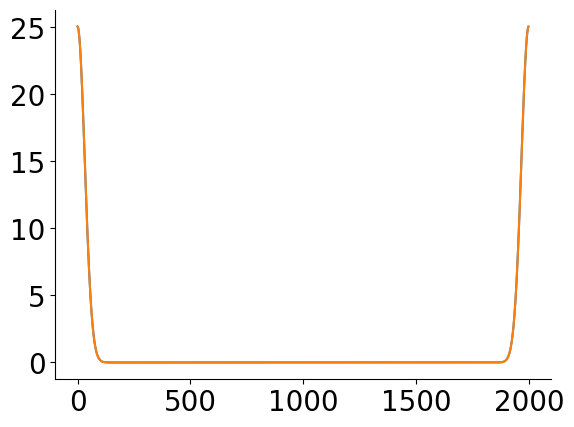

In [9]:
l = 0.2
start = 0
stop = 20
dt = 0.02
T = int((stop-start)/dt)
x_axis = np.linspace(start, stop-dt, T)

K = squared_exponential_kernel(x_axis[:, None] - x_axis[None, :], l)
x = np.random.randn(T)
kx = K.dot(x)
kx2 = sym_toeplitz_matmul2(torch.tensor(K[0]), torch.tensor(x[:, None])).flatten().numpy()
print(np.allclose(kx, kx2), np.linalg.norm(kx - kx2))

def se_fourier(f, l):
    omega = 2*np.pi*f
    prefactor =  np.sqrt(2 * np.pi)/l
    return prefactor * torch.exp(-((omega*l)**2) / 2)

kx3 = fourier_toeplitz_matmul(fourier_func=se_fourier, func_args={'l': l}, tensor=torch.tensor(x[:, None]), matrix_shape=(T, ), dt=dt, T=T).flatten().numpy()
print(np.allclose(kx, kx3), np.linalg.norm(kx - kx3))


# K = np.random.randn(2, 3, 4)
# x = np.random.randn(4, 2)
# kx2 = sym_toeplitz_matmul2(torch.tensor(K), torch.tensor(x)).flatten().numpy()
# print(torch.tensor(K).shape)
# print(kx2.shape)

In [13]:
# Your vector of length N
vector = torch.tensor([1, 2, 3, 4])

# The desired shape (K, L, M, N)
desired_shape = (2, 3, 4, vector.shape[0])

# Calculate the number of dimensions to add
num_dims_to_add = len(desired_shape) - 1

# Expand the vector to the desired shape
result = vector
for _ in range(num_dims_to_add):
    result = result.unsqueeze(0)

# Expand the result to the final shape and repeat the values
result = result.expand(*desired_shape)
print(result.shape)

# If you want the result as a tensor
print(result)

torch.Size([2, 3, 4, 4])
tensor([[[[1, 2, 3, 4],
          [1, 2, 3, 4],
          [1, 2, 3, 4],
          [1, 2, 3, 4]],

         [[1, 2, 3, 4],
          [1, 2, 3, 4],
          [1, 2, 3, 4],
          [1, 2, 3, 4]],

         [[1, 2, 3, 4],
          [1, 2, 3, 4],
          [1, 2, 3, 4],
          [1, 2, 3, 4]]],


        [[[1, 2, 3, 4],
          [1, 2, 3, 4],
          [1, 2, 3, 4],
          [1, 2, 3, 4]],

         [[1, 2, 3, 4],
          [1, 2, 3, 4],
          [1, 2, 3, 4],
          [1, 2, 3, 4]],

         [[1, 2, 3, 4],
          [1, 2, 3, 4],
          [1, 2, 3, 4],
          [1, 2, 3, 4]]]])
